In [ ]:
# Ваше решение
!pip install --upgrade keras==3.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.1/997.1 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.0.0 which is incompatible.


In [ ]:
import keras
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow import data as tf_data
import os
import random
from keras import layers
from keras.applications import EfficientNetV2B0

In [ ]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
!wget https://storage.yandexcloud.net/academy.ai/stanford_dogs.zip
!unzip -qo "stanford_dogs.zip" -d ./dataset

--2024-06-02 19:31:49--  https://storage.yandexcloud.net/academy.ai/stanford_dogs.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 774907490 (739M) [application/x-zip-compressed]
Saving to: ‘stanford_dogs.zip’

stanford_dogs.zip   100%[===================>] 739.01M  28.2MB/s    in 28s     

2024-06-02 19:32:18 (26.6 MB/s) - ‘stanford_dogs.zip’ saved [774907490/774907490]



In [ ]:
IMAGE_PATH = './dataset/'
num_skipped = 0
for folder_name in os.listdir(IMAGE_PATH):
    folder_path = os.path.join(IMAGE_PATH, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            os.remove(fpath)
print(f"Удалено изображений: {num_skipped}")

Удалено изображений: 10


In [ ]:
all_classes = sorted(os.listdir(IMAGE_PATH))
selected_classes = random.sample(all_classes, 10)
selected_image_paths = [os.path.join(IMAGE_PATH, class_name) for class_name in selected_classes]

print(f'Выбранные породы: {selected_classes}')

Выбранные породы: ['Scotch_terrier', 'Norwich_terrier', 'Great_Pyrenees', 'Dhole', 'Chesapeake_Bay_retriever', 'Shetland_sheepdog', 'Chihuahua', 'Chow', 'Giant_schnauzer', 'Newfoundland']


In [ ]:
train_ds = keras.utils.image_dataset_from_directory(
    IMAGE_PATH,
    validation_split=0.2,
    subset="training",
    seed=42,
    shuffle=True,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    labels="inferred",
    class_names=selected_classes
)

val_ds = keras.utils.image_dataset_from_directory(
    IMAGE_PATH,
    validation_split=0.2,
    subset="validation",
    seed=42,
    shuffle=True,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    labels="inferred",
    class_names=selected_classes
)

CLASS_LIST = selected_classes
CLASS_COUNT = len(CLASS_LIST)
print(f'Количество классов: {CLASS_COUNT}')
print(f'Метки классов: {CLASS_LIST}')

Found 1728 files belonging to 10 classes.
Using 1383 files for training.
Found 1728 files belonging to 10 classes.
Using 345 files for validation.
Количество классов: 10
Метки классов: ['Scotch_terrier', 'Norwich_terrier', 'Great_Pyrenees', 'Dhole', 'Chesapeake_Bay_retriever', 'Shetland_sheepdog', 'Chihuahua', 'Chow', 'Giant_schnauzer', 'Newfoundland']


In [ ]:
img_augmentation_layers = [
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1),
]

def img_augmentation(images):
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

train_ds = train_ds.map(
    lambda img, label: (img_augmentation(img), keras.utils.to_categorical(label, num_classes=CLASS_COUNT)),
    num_parallel_calls=tf_data.AUTOTUNE,
)

val_ds = val_ds.map(
    lambda img, label: (img, keras.utils.to_categorical(label, num_classes=CLASS_COUNT)),
    num_parallel_calls=tf_data.AUTOTUNE,
)

train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

In [ ]:
def build_model(num_classes):
    inputs = layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    model = EfficientNetV2B0(include_top=False, input_tensor=inputs, weights="imagenet")
    model.trainable = False

    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)
    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    model = keras.Model(inputs, outputs, name="EfficientNetV2B0")
    optimizer = keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["acc"])
    return model

model = build_model(num_classes=CLASS_COUNT)
epochs = 20

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath='best_model_pretrain.keras', monitor='val_acc', save_best_only=True, mode='max', verbose=0)
]

history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=callbacks)

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 129s 3s/step - acc: 0.6546 - loss: 1.5175 - val_acc: 0.9536 - val_loss: 0.1335
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - acc: 0.8566 - loss: 0.6721 - val_acc: 0.9739 - val_loss: 0.1000
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - acc: 0.8637 - loss: 0.7548 - val_acc: 0.9536 - val_loss: 0.1333
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - acc: 0.8786 - loss: 0.7117 - val_acc: 0.9565 - val_loss: 0.1320
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - acc: 0.8891 - loss: 0.7113 - val_acc: 0.9681 - val_loss: 0.1036
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - acc: 0.8799 - loss: 0.7131 - val_acc: 0.9536 - val_loss: 0.1342
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - acc: 0.8671 - loss: 0.6340 - val_acc: 0.9101 - val_loss: 0.3791
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 149s 3s/step - acc: 0.8824 - loss: 0.6596 - val_acc: 0.9710 - val_loss: 0.1851
Epoch 9/20
44

In [ ]:
def unfreeze_model(model):
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["acc"])

unfreeze_model(model)
epochs = 4
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/4
44/44 ━━━━━━━━━━━━━━━━━━━━ 130s 3s/step - acc: 0.9083 - loss: 0.4878 - val_acc: 0.9681 - val_loss: 0.2835
Epoch 2/4
44/44 ━━━━━━━━━━━━━━━━━━━━ 139s 3s/step - acc: 0.9149 - loss: 0.3808 - val_acc: 0.9652 - val_loss: 0.2746
Epoch 3/4
44/44 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - acc: 0.9160 - loss: 0.4646 - val_acc: 0.9623 - val_loss: 0.2839
Epoch 4/4
44/44 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - acc: 0.9258 - loss: 0.3766 - val_acc: 0.9681 - val_loss: 0.2688


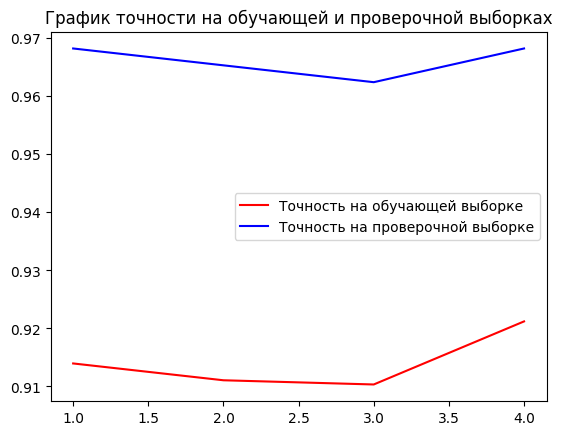

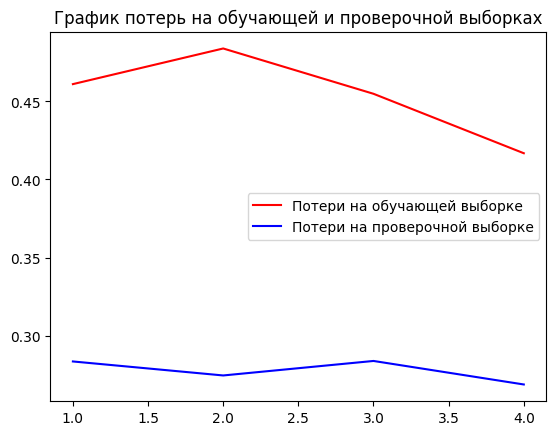

In [ ]:
def show_plot(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'r', label='Точность на обучающей выборке')
    plt.plot(epochs, val_acc, 'b', label='Точность на проверочной выборке')
    plt.title('График точности на обучающей и проверочной выборках')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'r', label='Потери на обучающей выборке')
    plt.plot(epochs, val_loss, 'b', label='Потери на проверочной выборке')
    plt.title('График потерь на обучающей и проверочной выборках')
    plt.legend()
    plt.show()

show_plot(history)

--2024-06-02 20:26:41--  https://storage.yandexcloud.net/academy.ai/Cardigan.jpeg
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47310 (46K) [image/jpeg]
Saving to: ‘Cardigan.jpeg’

Cardigan.jpeg       100%[===================>]  46.20K  --.-KB/s    in 0.1s    

2024-06-02 20:26:42 (316 KB/s) - ‘Cardigan.jpeg’ saved [47310/47310]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


(-0.5, 223.5, 223.5, -0.5)

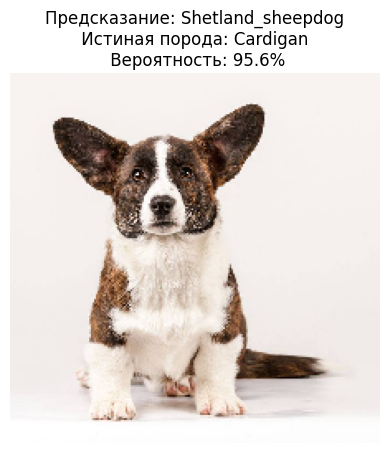

In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/Cardigan.jpeg
TEST_IMG='./Cardigan.jpeg'

img = keras.utils.load_img(TEST_IMG, target_size=(IMAGE_SIZE[0], IMAGE_SIZE[1])) # Загружаем картинку
plt.imshow(img)


img_array = keras.utils.img_to_array(img) # Преобразуем картинку в тензор
img_array = keras.ops.expand_dims(img_array, 0)  # Создание дополнительного измерения для батча

predictions = model.predict(img_array)


plt.title("Предсказание: %s\n Истиная порода: Cardigan \n Вероятность: %2.1f%%" %
 (CLASS_LIST[keras.ops.argmax(predictions)],
  keras.ops.max(predictions)*100)  ) # Вывод метки
plt.axis("off")

**Примечание**. В 2021 году появилась вторая версия модели EfficientNetV2 (https://arxiv.org/pdf/2104.00298.pdf), которая была добавлена в Keras.